In [1511]:
import numpy as np
import nest
import nest.raster_plot
import matplotlib.pyplot as plt
from statistics import median_high, median_low

In [1513]:
nest.ResetKernel()
nest.resolution = 0.1

ipds = [0,45,90,135,180,225,270,315,360]
ipd = ipds[3]

t_simulation = 1000
rate_max = 104000.0
f = 3.0

n_cd = 100
cd_tau_m = 4.0
cd_c_m = 250.0
cd_tau_syn_ex = 1.65
cd_v_th = -55.0

rate_max_single_ear = 208000.0 #rate doubled to see the effect of the single ears
d_factor = 1


Feb 22 19:36:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [1514]:
ear = nest.Create('sinusoidal_poisson_generator', n=2,
                params={'rate': [rate_max/2, rate_max/2],
                        'amplitude': [rate_max/2, rate_max/2],
                        'frequency': [f, f],
                        'phase': [0.0, ipd]})


best_itds = np.array(np.linspace(0.1, (1/f)*1000/d_factor, n_cd))
best_ipds = best_itds*2*np.pi*f/1000
syn_delays = np.transpose([np.ones(n_cd)/10, best_itds])

cd = nest.Create('iaf_psc_alpha', n_cd,
                params={'tau_m':cd_tau_m,
                        'C_m': cd_c_m,
                        'tau_syn_ex': cd_tau_syn_ex,
                        'V_th': cd_v_th
                } )
syn_spec_dict ={'delay':syn_delays}
nest.Connect(ear, cd, syn_spec=syn_spec_dict)


m0 = nest.Create('multimeter', {'interval': 0.1, 'record_from': ['rate']})
s0 = nest.Create('spike_recorder')
s1 = nest.Create('spike_recorder')
m1 = nest.Create('multimeter', {'interval': 0.1, 'record_from': ['V_m']})

nest.Connect(m0, ear, 'all_to_all')
nest.Connect(ear, s0, 'all_to_all')
nest.Connect(cd, s1, 'all_to_all')
nest.Connect(m1, cd, 'all_to_all')

nest.Simulate(t_simulation)
m0_data = m0.get("events")
s0_data = s0.get("events")
m1_data = m1.get("events")
s1_data = s1.get("events")

############################
nest.ResetKernel()
nest.resolution = 0.1
rate_max = 100000.0
ear1 = nest.Create('sinusoidal_poisson_generator',
                params={'rate': rate_max_single_ear/2,
                        'amplitude': rate_max_single_ear/2,
                        'frequency': f,
                        'phase': 0.0})
cd = nest.Create('iaf_psc_alpha', n_cd,
                params={'tau_m':cd_tau_m,
                        'C_m': cd_c_m,
                        'tau_syn_ex': cd_tau_syn_ex,
                        'V_th': cd_v_th})
syn_spec_dict ={'delay':0.1}
nest.Connect(ear1, cd, syn_spec=syn_spec_dict)
s2 = nest.Create('spike_recorder')
nest.Connect(cd, s2, 'all_to_all')
nest.Simulate(t_simulation)
s2_data = s2.get("events")
############################
nest.ResetKernel()
nest.resolution = 0.1
ear2 = nest.Create('sinusoidal_poisson_generator',
                params={'rate': rate_max_single_ear/2,
                        'amplitude': rate_max_single_ear/2,
                        'frequency': f,
                        'phase': ipd})
best_itds = np.array(np.linspace(0.1, (1/f)*1000/d_factor, n_cd))
cd = nest.Create('iaf_psc_alpha', n_cd,
                 params={'tau_m':cd_tau_m,
                        'C_m': cd_c_m,
                        'tau_syn_ex': cd_tau_syn_ex,
                        'V_th': cd_v_th})
                        
syn_spec_dict ={'delay':best_itds}
nest.Connect(np.ones(n_cd, dtype = int), cd,'one_to_one', syn_spec=syn_spec_dict)
s3 = nest.Create('spike_recorder')
nest.Connect(cd, s3, 'all_to_all')
nest.Simulate(t_simulation)
s3_data = s3.get("events")


Feb 22 19:36:39 NodeManager::prepare_nodes [Info]: 
    Preparing 106 nodes for simulation.

Feb 22 19:36:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 106
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Feb 22 19:36:40 SimulationManager::run [Info]: 
    Simulation finished.

Feb 22 19:36:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 22 19:36:40 NodeManager::prepare_nodes [Info]: 
    Preparing 102 nodes for simulation.

Feb 22 19:36:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 102
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Feb 22 19:36:41 SimulationManager::run [Info]: 
    Simulation finished.

Feb 22 19:36:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Feb 22 19:36:41 NodeManager::prepare_nodes [Info]: 
    Preparing 102 nodes f

real IPD: 2.36 rad, 135 deg
predicted IPD:  2.29 rad, 130.98 deg
approximation error: 4.02 deg 2.98 %
predicted ITD: 121.28 ms
best CD neuron: 36


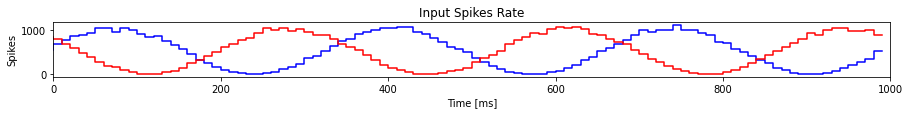

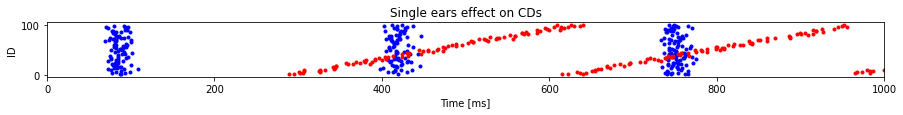

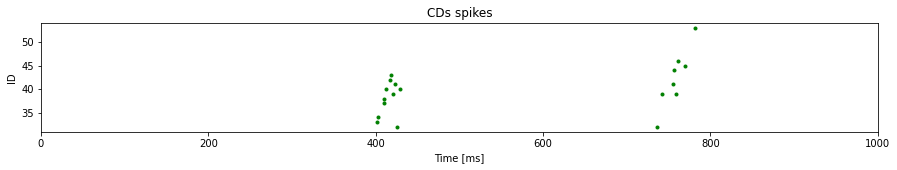

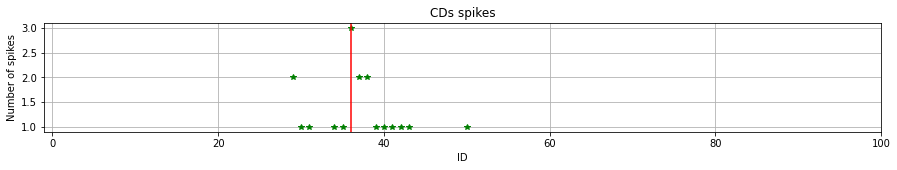

In [1515]:
plt.figure(figsize=(15, 1))
histogram_resolution = 100
ts_e1 = s0_data['times'][np.where(s0_data['senders']==1)]
ts_e2 = s0_data['times'][np.where(s0_data['senders']==2)]
s_e1, b1 = np.histogram(ts_e1, histogram_resolution)
plt.step(b1[:-1], s_e1, color = colors[0])
s_e2, b2 = np.histogram(ts_e2, histogram_resolution)
plt.step(b2[:-1], s_e2, color = colors[1])
plt.xlim(0,t_simulation)
plt.title("Input Spikes Rate")
plt.ylabel("Spikes")
plt.xlabel("Time [ms]")

plt.figure(figsize=(15, 1))
plt.plot(s2_data['times'], s2_data['senders'], ".", color = colors[0])
plt.xlim(0,t_simulation)
plt.plot(s3_data['times'], s3_data['senders'], ".", color = colors[1])
plt.xlim(0,t_simulation)
plt.title("Single ears effect on CDs")
plt.ylabel("ID")
plt.xlabel("Time [ms]")

plt.figure(figsize=(15, 2))
plt.plot(s1_data['times'], s1_data['senders'], ".", color = colors[2])
plt.xlim(0,t_simulation)
plt.title("CDs spikes")
plt.ylabel("ID")
plt.xlabel("Time [ms]")

plt.figure(figsize=(15, 2))
cd_id, spikes = np.unique(s1_data['senders'], return_counts=True)
cd_id = cd_id-3
plt.plot(cd_id, spikes, '*', color = colors[2])
plt.grid()
plt.xlim(-1,100)
plt.title("CDs spikes")
plt.ylabel("Number of spikes")
plt.xlabel("ID")

#best_cd_id = cd_id[np.argmax(spikes)]
#best_cd_id = np.mean(cd_id[np.argwhere(spikes == np.amax(spikes))], dtype=int)
best_cd_id = median_high(cd_id[np.argwhere(spikes == np.amax(spikes))])[0]

predicted_itd = best_itds[best_cd_id]
predicted_ipd = best_ipds[best_cd_id]
predicted_ipd_deg = predicted_ipd*180/np.pi

ap_error = (abs(ipd-predicted_ipd_deg)/ipd) * 100
print("real IPD:", round(ipd*np.pi/180,2), "rad,", ipd, "deg")
print("predicted IPD: ", round(predicted_ipd,2), "rad,", round(predicted_ipd_deg,2), "deg")
print("approximation error:", round(ipd-predicted_ipd_deg,2), "deg", round(ap_error,2), "%")
print("predicted ITD:", round(predicted_itd,2), "ms")
print("best CD neuron:", best_cd_id)
plt.axvline(best_cd_id, color = 'r')